In [24]:
#In this competition your sumbission will be a training data not predictions
#your task is to improve the dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import linear_model

sample_submission = pd.read_csv('/content/sample_data/sample_submission.csv')
sample_submission.head()

,id,target,O2_1,O2_2,O2_3,O2_4,O2_5,O2_6,O2_7,NH4_1,...,NO3_5,NO3_6,NO3_7,BOD5_1,BOD5_2,BOD5_3,BOD5_4,BOD5_5,BOD5_6,BOD5_7
0,0,8.59,7.500,9.00,9.545,9.265,8.110,8.43,7.15,0.180,...,4.95,1.730,1.800,4.800,3.15,10.665,10.465,16.645,5.75,10.37
1,1,9.10,13.533,40.90,8.770,9.265,6.015,10.07,7.15,1.107,...,20.05,9.530,7.695,4.550,6.95,2.040,5.200,5.725,2.95,2.23
2,2,8.21,3.710,5.42,8.770,9.265,4.550,10.07,7.15,0.020,...,4.58,3.025,3.960,4.935,4.95,4.725,6.075,6.750,3.50,3.17
3,3,8.39,8.700,8.10,9.500,9.200,5.200,8.67,6.67,0.280,...,8.45,2.070,1.730,6.300,4.70,3.500,6.200,8.670,2.90,7.37
4,4,8.07,8.050,8.65,7.960,9.265,3.290,10.07,7.15,0.360,...,2.02,1.730,0.760,4.800,4.97,3.950,2.800,8.400,3.50,3.90


In [25]:
def summary(df):
    sum = pd.DataFrame(df.dtypes, columns=['dtypes'])
    sum['missing#'] = df.isna().sum().values*100
    sum['missing%'] = (df.isna().sum().values*100)/len(df)
    sum['uniques'] = df.nunique().values
    sum['count'] = df.count().values
    sum['skew'] = df.skew().values
    desc = pd.DataFrame(df.describe().T)
    sum['min'] = desc['min']
    sum['max'] = desc['max']
    sum['mean'] = desc['mean']
    return sum

summary(sample_submission).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,skew,min,max,mean
id,int64,0,0.000000,3500,3500,0.000000,0.000000,3499.000000,1749.500000
target,float64,0,0.000000,462,3500,10.460854,1.300000,65.930000,8.473834
O2_1,float64,0,0.000000,329,3500,7.753354,0.000000,46.950000,8.216993
O2_2,float64,0,0.000000,258,3500,4.314217,0.000000,65.950000,9.291581
O2_3,float64,0,0.000000,235,3500,1.254857,4.900000,16.900000,9.633064
O2_4,float64,0,0.000000,241,3500,0.782568,2.300000,21.800000,8.065733
O2_5,float64,0,0.000000,317,3500,3.740421,0.200000,59.400000,5.671581
O2_6,float64,0,0.000000,238,3500,5.246618,0.000000,40.190000,9.461363
O2_7,float64,0,0.000000,303,3500,0.285303,0.000000,15.900000,6.547433
NH4_1,float64,0,0.000000,152,3500,3.237432,0.020000,4.200000,0.340525


<Figure size 1000x800 with 0 Axes>

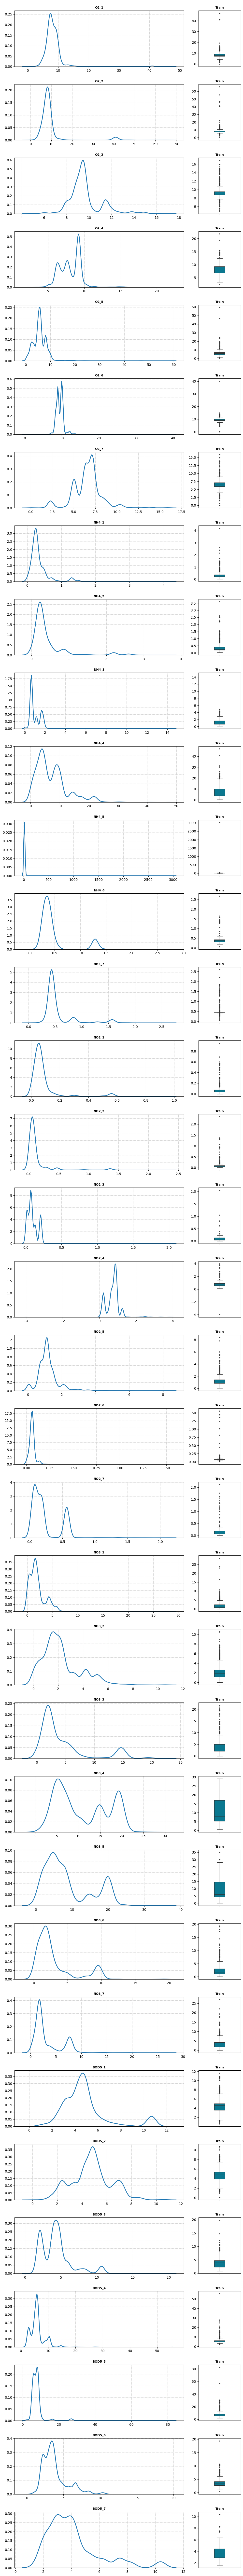

In [26]:
target = 'target'
num_var = sample_submission.columns.drop(['target','id'])

#Let's take a look at the distribution of different features.
plt.figure(figsize=(10, 8));
fig, axes = plt.subplots(len(num_var), 2 ,figsize=(10, len(num_var) * 3), gridspec_kw={'width_ratios': [4, 1]});

for i,col in enumerate(num_var):
    ax = axes[i,0];
    sns.kdeplot(data = sample_submission, x = col, ax = ax, linewidth = 2.1)
    ax.set_title(f"\n{col}",fontsize = 9, fontweight= 'bold');
    ax.grid(visible=True, which = 'both', linestyle = '--', color='lightgrey', linewidth = 0.75);
    ax.set(xlabel = '', ylabel = '');

    ax = axes[i,1];
    sns.boxplot(data = sample_submission, y = col, width = 0.25,saturation = 0.90, linewidth = 0.90, fliersize= 2.25, color = '#037d97',
                ax = ax);
    ax.set(xlabel = '', ylabel = '');
    ax.set_title(f"Train",fontsize = 9, fontweight= 'bold');

plt.tight_layout();
plt.show();

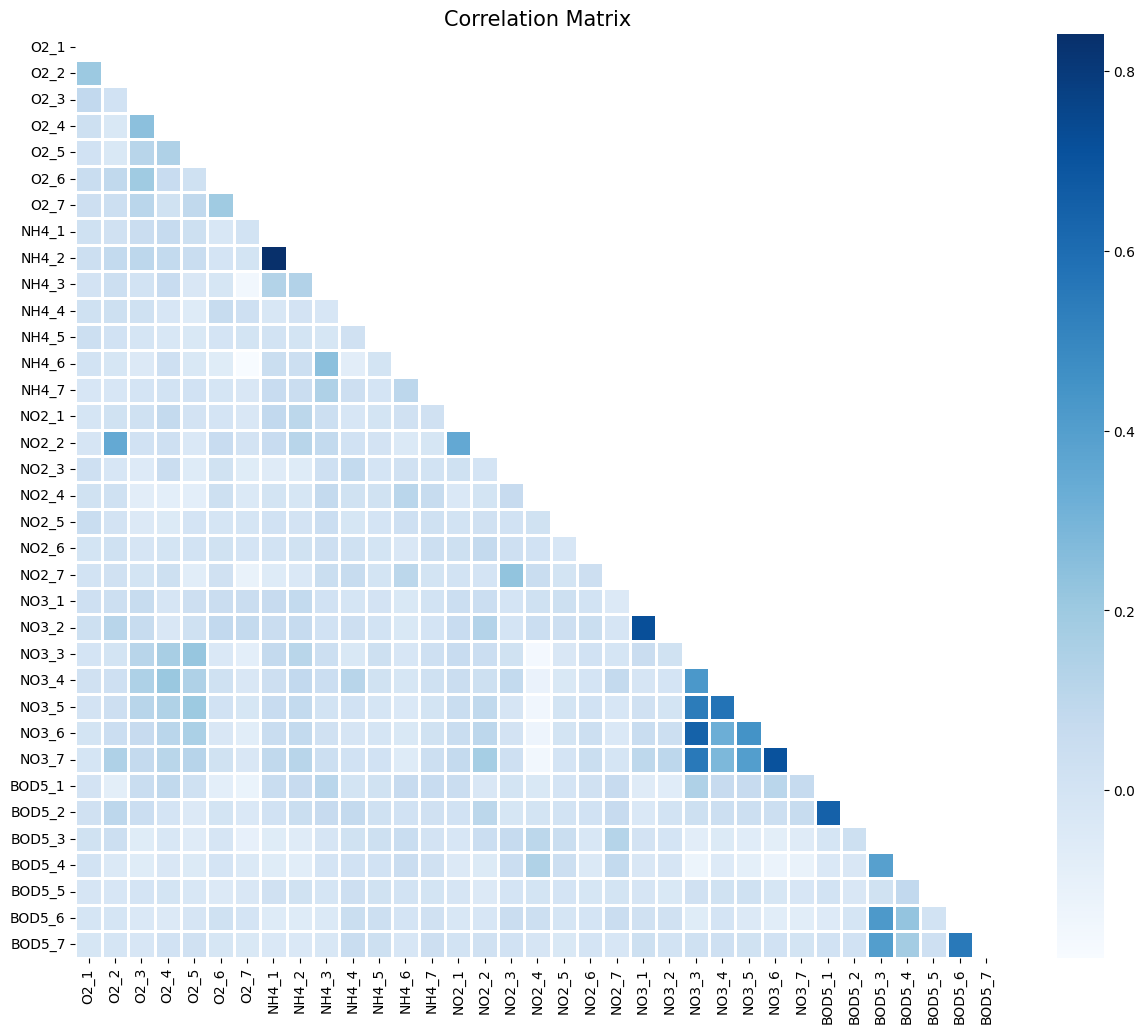

In [27]:
corr_matrix = sample_submission[num_var].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

In [28]:
rf = RandomForestRegressor(
       n_estimators=1000,
       max_depth=7,
       n_jobs=-1,
       random_state=42)

mse_results = pd.DataFrame(columns=['Selected_Features','MSE'])

def evaluation (df, selected_features, note):
  global mse_results
  X = df[selected_features]
  Y = df[target]
  mse_scores = []

  kf = KFold(n_splits=5, shuffle=True, random_state=42)

  for train_idx, test_idx in kf.split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx] #seperates the features(independent) variables into training and testing part
    y_train, y_test = Y.iloc[train_idx],Y.iloc[test_idx]  #seperates the target variables into training and testing part

    rf.fit(X_train, y_train)
    y_hat = rf.predict(X_test)
    mse = mean_squared_error(y_test, y_hat)
    mse_scores.append(mse)

  average_mse = np.mean(mse_scores)
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)

  print('====================================')
  print(note)
  #the goal is to reduce this mse score
  print("Average MSE:", average_mse)
  print('====================================')

In [29]:
#baseline evaluation
evaluation(df=sample_submission,selected_features=num_var,note='Baseline')

Baseline
Average MSE: 2.3171538130551967


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


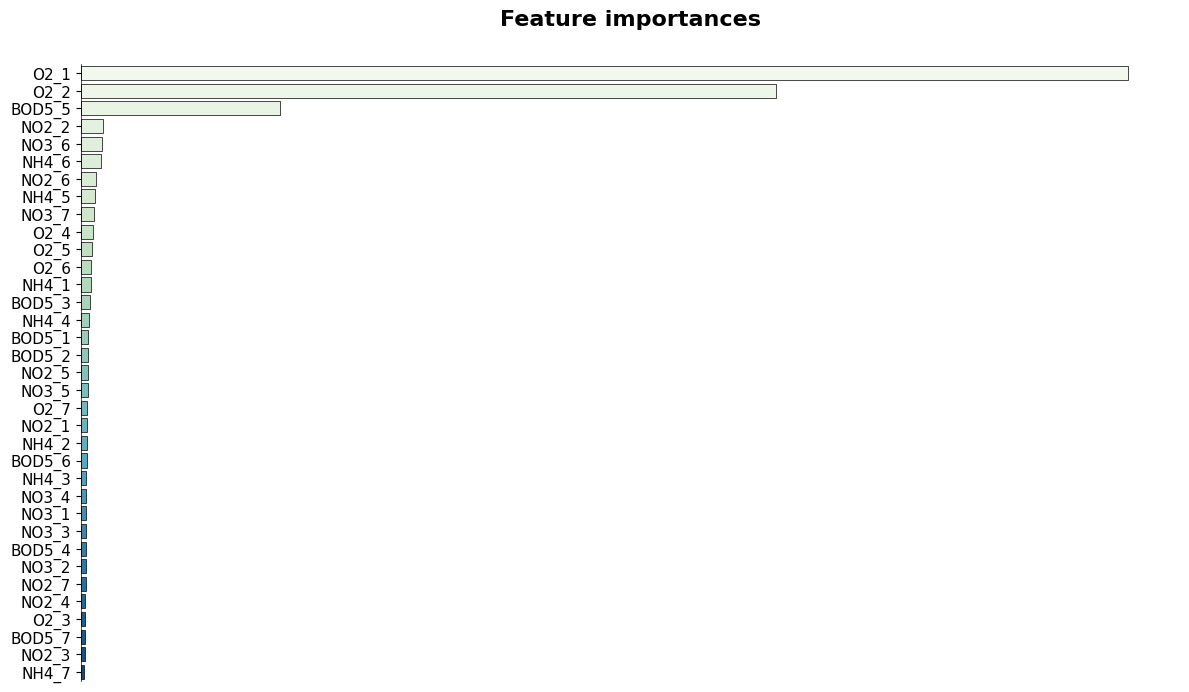

In [30]:
f_imp_df = pd.DataFrame({'feature':num_var,'imp': rf.feature_importances_}) #feature_importances_ attribute is used to obtain the importance scores of each feature in the model
f_imp_df.sort_values(by='imp',ascending=False,inplace=True)

#Helper to plot feature importance
def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title(f'Feature importances', size=16, y=1.05,
              fontweight='bold')
    a = sns.barplot(data=f_imp, x='imp', y='feature', linestyle="-",
                    linewidth=0.5, edgecolor="black",palette='GnBu')
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11)

    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()

f_importance_plot(f_imp_df)

In [31]:
top3_features = f_imp_df.head(3).feature.to_list()
top4_features = f_imp_df.head(4).feature.to_list()
print(top3_features)
print(top4_features)

['O2_1', 'O2_2', 'BOD5_5']
['O2_1', 'O2_2', 'BOD5_5', 'NO2_2']


**Data Preprocessing**

In [32]:
#evaluation top3 features and top4features

#removing values below 6.5
submission = sample_submission[sample_submission['target'] > 6.5] #trick

evaluation_top3 = evaluation(df=submission, selected_features=top3_features, note="Top 3 features + trick")
evaluation_top4 = evaluation(df=submission, selected_features=top4_features, note="Top 4 features + trick")
print(evaluation_top3)
print(evaluation_top4)

<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Top 3 features + trick
Average MSE: 2.0748605728615988
Top 4 features + trick
Average MSE: 1.944591842025298
None
None


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


In [33]:
# Clip outliner
submission_20 = sample_submission.copy()
submission_20.target = submission_20.target.clip(upper=20)

submission_35 = sample_submission.copy()
submission_35.target = submission_35.target.clip(upper=35)

evaluation(df=submission_20,selected_features=top3_features,note='Clip(20) + Top 3 Features')
evaluation(df=submission_20,selected_features=top4_features,note='Clip(20) + Top 4 Features')

evaluation(df=submission_35,selected_features=top3_features,note='Clip(35) + Top 3 Features')
evaluation(df=submission_35,selected_features=top4_features,note='Clip(35) + Top 4 Features')

<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(20) + Top 3 Features
Average MSE: 1.202855473117649


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(20) + Top 4 Features
Average MSE: 1.1530128708107457


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(35) + Top 3 Features
Average MSE: 1.524030801350436
Clip(35) + Top 4 Features
Average MSE: 1.4623760758700939


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


In [34]:
# Clip 20 + SGD
submission_20_sgd = submission_20.copy()
clf = linear_model.SGDOneClassSVM(nu=0.55).fit(submission_20_sgd.drop(['id'],axis=1))
outlier_indices = clf.predict(submission_20_sgd.drop(['id'],axis=1)) == -1
submission_20_sgd = submission_20_sgd.iloc[~outlier_indices]

# Clip 35 + SGD
submission_35_sgd = submission_35.copy()
clf = linear_model.SGDOneClassSVM(nu=0.55).fit(submission_35_sgd.drop(['id'],axis=1))
outlier_indices = clf.predict(submission_35_sgd.drop(['id'],axis=1)) == -1
submission_35_sgd = submission_35_sgd.iloc[~outlier_indices]

evaluation(df=submission_20_sgd,selected_features=top3_features,note='Clip(20) + SGD + Top 3 Features')
evaluation(df=submission_20_sgd,selected_features=top4_features,note='Clip(20) + SGD + Top 4 Features')

evaluation(df=submission_20_sgd,selected_features=top3_features,note='Clip(20) + SGD + Top 3 Features')
evaluation(df=submission_20_sgd,selected_features=top4_features,note='Clip(20) + SGD + Top 4 Features')

<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(20) + SGD + Top 3 Features
Average MSE: 1.185372239335799


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(20) + SGD + Top 4 Features
Average MSE: 1.1497253181420646


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(20) + SGD + Top 3 Features
Average MSE: 1.185372239335799
Clip(20) + SGD + Top 4 Features
Average MSE: 1.1497253181420646


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


In [35]:
#Isolation Forest
#The Isolation Forest algorithm performs anomaly detection on the data.
#  Anomaly or outliers are the ones that deviate from the majority of data points in the dataset, that mybe rare events, errors, or unusual patterns
# Anomalies are more likely to be isolated in smaller partitions, while normal data points are expected to be grouped together in larger partitions.

# Clip 20 + IF
submission_20_if = submission_20.copy()
clf = IsolationForest(random_state=0).fit(submission_20_if.drop(['id'],axis=1))
outlier_indices = clf.predict(submission_20_if.drop(['id'],axis=1)) == -1
submission_20_if = submission_20_if.iloc[~outlier_indices]

# Clip 35 + IF
submission_35_if = submission_35.copy()
clf = IsolationForest(random_state=0).fit(submission_35_if.drop(['id'],axis=1))
outlier_indices = clf.predict(submission_35_if.drop(['id'],axis=1)) == -1
submission_35_if = submission_35_if.iloc[~outlier_indices]

evaluation(df=submission_20_if,selected_features=top3_features,note='Clip(20) + IF + Top 3 Features')
evaluation(df=submission_20_if,selected_features=top4_features,note='Clip(20) + IF + Top 4 Features')

evaluation(df=submission_35_if,selected_features=top3_features,note='Clip(35) + IF + Top 3 Features')
evaluation(df=submission_35_if,selected_features=top4_features,note='Clip(35) + IF + Top 4 Features')

<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(20) + IF + Top 3 Features
Average MSE: 1.1742046795646042


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(20) + IF + Top 4 Features
Average MSE: 1.1722515459318652


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(35) + IF + Top 3 Features
Average MSE: 1.520386738896054
Clip(35) + IF + Top 4 Features
Average MSE: 1.5166496836611443


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


In [36]:
# Clip + Isolation Forest(IF) + Top 3 Features or Top 4 features

evaluation(df=submission_20_if,selected_features=top3_features,note='Clip(20) + IF + Top 3 Features')
evaluation(df=submission_20_if,selected_features=top4_features,note='Clip(20) + IF + Top 4 Features')

evaluation(df=submission_35_if,selected_features=top3_features,note='Clip(35) + IF + Top 3 Features')
evaluation(df=submission_35_if,selected_features=top4_features,note='Clip(35) + IF + Top 4 Features')

<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(20) + IF + Top 3 Features
Average MSE: 1.1742046795646042


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(20) + IF + Top 4 Features
Average MSE: 1.1722515459318652


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(35) + IF + Top 3 Features
Average MSE: 1.520386738896054
Clip(35) + IF + Top 4 Features
Average MSE: 1.516649683661144


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


**Local Outlier Factor**
The LOF algorithm identifies outliers by comparing the local density of each data point.

In [37]:
# Clip 20 + LOF
submission_20_lof = submission_20.copy()
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
outlier_indices = lof.fit_predict(submission_20_lof.drop(['id'],axis=1)) == -1
submission_20_lof = submission_20_lof.iloc[~outlier_indices]

# Clip 35 + LOF
submission_35_lof = submission_35.copy()
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
outlier_indices = lof.fit_predict(submission_35_lof.drop(['id'],axis=1)) == -1
submission_35_lof = submission_35_lof.iloc[~outlier_indices]

evaluation(df=submission_20_lof,selected_features=top3_features,note='Clip(20) + LOF + Top 3 Features')
evaluation(df=submission_20_lof,selected_features=top4_features,note='Clip(20) + LOF + Top 4 Features')

evaluation(df=submission_35_lof,selected_features=top3_features,note='Clip(35) + LOF + Top 3 Features')
evaluation(df=submission_35_lof,selected_features=top4_features,note='Clip(35) + LOF + Top 4 Features')

<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(20) + LOF + Top 3 Features
Average MSE: 0.9841074082236906


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(20) + LOF + Top 4 Features
Average MSE: 0.9589650110209519


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


Clip(35) + LOF + Top 3 Features
Average MSE: 0.9583706551588549
Clip(35) + LOF + Top 4 Features
Average MSE: 0.933740441817096


<ipython-input-28-7ecbfc49eb9f>:27: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_results = mse_results.append({'Selected_Features': note, 'MSE': average_mse}, ignore_index=True)


In [38]:
mse_results.sort_values(by='MSE')

,Selected_Features,MSE
22,Clip(35) + LOF + Top 4 Features,0.933740
21,Clip(35) + LOF + Top 3 Features,0.958371
20,Clip(20) + LOF + Top 4 Features,0.958965
19,Clip(20) + LOF + Top 3 Features,0.984107
8,Clip(20) + SGD + Top 4 Features,1.149725
10,Clip(20) + SGD + Top 4 Features,1.149725
4,Clip(20) + Top 4 Features,1.153013
16,Clip(20) + IF + Top 4 Features,1.172252
12,Clip(20) + IF + Top 4 Features,1.172252
15,Clip(20) + IF + Top 3 Features,1.174205


In [39]:
df = pd.read_csv('/content/sample_data/sample_submission.csv')

df.target = df.target.clip(7,20)

# SGD
clf = linear_model.SGDOneClassSVM(nu=0.55).fit(df[num_var])
outlier_indices = clf.predict(df[num_var]) == -1
df = df.iloc[~outlier_indices]

# IsolationForest
lf = IsolationForest(random_state=0).fit(df[num_var])
outlier_indices = clf.predict(df[num_var]) == -1
df = df.iloc[~outlier_indices]

# LOF
lof = LocalOutlierFactor(n_neighbors=3, contamination=0.1)
outlier_indices = lof.fit_predict(df[num_var]) == -1
df = df.iloc[~outlier_indices]

lowest_quality_labels =  [2365, 1089, 1936, 1680, 211,2294,448, 437,309,1684]
df = df.iloc[~df.index.isin(lowest_quality_labels)]

df = df[df.target != 7]

col_to_keep = ['O2_1', 'O2_2', 'BOD5_5', 'target']

for i in df.columns:
    if i not in col_to_keep:
        df[i]=0

In [40]:
def set_zero(df,col_to_keep):
    col_to_keep.append(target) # Keep target in dataset
    df_sub = df.copy()
    for i in df_sub.columns:
        if i not in col_to_keep:
            df_sub[i] = 0
    return df_sub

In [41]:
# Combination + Top 3 Features
df.to_csv('submission.csv', index=False)

# Clip(35) + LOF + Top 3 Features
submission_35_sgd_3 = set_zero(submission_35_sgd,top3_features)
submission_35_sgd_3.to_csv('submission_sgd_1.csv', index=False)

# Clip(20) + LOF + Top 4 Features
submission_20_sgd_3 = set_zero(submission_20_sgd,top3_features)
submission_20_sgd_3.to_csv('submission_sgd_2.csv', index=False)